# PV Performance Model Validation
<li><b>1. Import data from DuraMAT</b></li>
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx
<li><b>2. Define relevant system & meteo data</b></li>
<li><b>3. Run model to be validated or import model results</b></li>
<li><b>4. Compare model to measured results and other baseline models</b></li>

In [122]:
pd.options.mode.chained_assignment = None

In [283]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import pvlib
import pvanalytics
import sklearn.metrics
import scipy
from matplotlib.lines import Line2D 
from tabulate import tabulate

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size']=12
plt.rcParams['lines.linewidth']=1.25
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.titlesize']=12

## 1. Import data

In [284]:
df = pd.read_excel('pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx', sheet_name='S2')
#df = pd.read_excel(https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx,
#                   sheet_name='S2'

#Reassigning the index so the timesteps are at the middle of the hour
df.index = pd.date_range(start='2021-01-01 00:30:00', end='2021-12-31 23:30:00', freq='H')
df.index = df.index.tz_localize('MST')

df = df.where((df['bsrn_pass'] == 1) & (df['SNL No Snow'] == 1) & (df['Measured DC power (W)'] > 1)).dropna()
df.replace(0, np.nan, inplace=True)
df.dropna(inplace=True)

df.head()

,Scenario,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),Measured front POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),bsrn_pass,SNL No Snow
2021-01-01 08:30:00-07:00,S2,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,442.132104,6.645174,1292.814741,1.0,1.0
2021-01-01 09:30:00-07:00,S2,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,701.031595,17.712519,2276.603041,1.0,1.0
2021-01-01 10:30:00-07:00,S2,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.089500,2.962067,879.164182,25.669461,2782.780150,1.0,1.0
2021-01-01 11:30:00-07:00,S2,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,977.788429,35.226433,2989.486270,1.0,1.0
2021-01-01 12:30:00-07:00,S2,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,922.354253,38.056121,2796.495393,1.0,1.0


## 2. Define system and meteo data

pan file \
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/a3862674-3a50-4b28-817d-4885ce5f551d/download/pan-canadian-solar_cs6k-275m_dec2019_cfv.pan_.txt

iec matrix \
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/4f36a75e-8afb-40e9-b9c3-ed2e562a2a45/download/iec61853-1_sandia_pv_module_p-matrix-and-tempco-data_2019.xlsx

test reports \
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/6bf975f3-1134-4a2f-82f3-a56b25e97f36/download/pan-file-report-canadian-solar-cs6k-275m.pdf \
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/22b38afc-2625-4005-8b42-70c4a1b4a9ca/download/test-report-iamnmot-canadian-solar-cs6k-275m.pdf

spec sheet \
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/a2cb566b-2227-46e3-8768-61d1d21df456/download/specsheet_cs_cs6k-275m.pdf

Solar position & Irradiance components

In [285]:
#Defining system constants 
module = {'Tilt': 35,'Latitude': 35.05,'Longitude': -106.54,'Altitude': 1600,'Surface Azimuth': 180,'String Length':12, 'Area':1.621, 'Pmp' : 275, 'Gamma Pmp': -0.0041, 'iam0':1,'iam10': 0.9989, 'iam20': 1.0014, 'iam30': 1.0002, 
          'iam40':0.9984, 'iam45': 0.9941, 'iam50': 0.9911, 'iam55': 0.9815, 'iam60':0.9631, 'iam65':0.9352, 'iam70':0.8922, 'iam75':0.8134, 'iam80':0.6778, 'iam85': 0.4351}
module = pd.Series(module)
dataCan = {'Irradiance': [100, 200, 400, 600, 800, 1000, 1100], 'Relative Efficiency': [0.923314066, 0.957349138,0.981810786,0.993869356,0.997680967,1,0.99875193]}
efficiency = pd.DataFrame(dataCan)

#Running solar position calculations
#Calculate Solar Positions & Extraterrestrial DNI

spdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['Latitude'], 
        longitude=module['Longitude'],temperature=df['Ambient Temp (°C) '], altitude=module['Altitude'])
spdf['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)
pres = pvlib.atmosphere.alt2pres(module['Altitude'])

#Save these values into the df with inputs & results for use in later analysis
df['Azimuth'] = spdf['azimuth']
df['Zenith'] = spdf['apparent_zenith']
df['Sol Elev'] = spdf['elevation']
df['Clearness Index'] = pvlib.irradiance.clearness_index(ghi=df['GHI (W/m2)'], solar_zenith=spdf['apparent_zenith'], extra_radiation = spdf['dni_extra'])
spdf.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,dni_extra
2021-01-01 08:30:00-07:00,77.884310,77.950122,12.115690,12.049878,129.546848,-3.734135,1413.981805
2021-01-01 09:30:00-07:00,69.241432,69.279260,20.758568,20.720740,140.756151,-3.753597,1413.981805
2021-01-01 10:30:00-07:00,62.615700,62.643406,27.384300,27.356594,154.026282,-3.773049,1413.981805
2021-01-01 11:30:00-07:00,58.731118,58.754688,31.268882,31.245312,169.230769,-3.792492,1413.981805
2021-01-01 12:30:00-07:00,58.153100,58.176057,31.846900,31.823943,185.427677,-3.811925,1413.981805


In [286]:
#Calculate Environmental Conditions

edf = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
        solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'],dni=df['DNI (W/m2)'],
        ghi=df['GHI (W/m2)'], dhi=df['DHI (W/m2)'], dni_extra=spdf['dni_extra'], model ='perez', model_perez='albuquerque1988')
edf['aoi'] = pvlib.irradiance.aoi(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
        solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'])
edf['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=spdf['apparent_zenith'])
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=edf['airmass'], pressure=pres)
df['AOI'] = edf['aoi']

In [287]:
#Calculate Effective Irradiance

ref_thetas= [0,10,20,30,40,45,50,55,60,65,70,75,80,85]
ref_iams = [module['iam0'],module['iam10'],module['iam20'],module['iam30'],module['iam40'],module['iam45'],module['iam50'],
            module['iam55'],module['iam60'],module['iam65'],module['iam70'],module['iam75'],module['iam80'],module['iam85']]
F2 = pvlib.iam.interp(aoi=edf['aoi'],theta_ref=ref_thetas,iam_ref=ref_iams )
df['Effective Irradiance'] = (edf['poa_direct'] * F2 + edf['poa_diffuse'])
df['IAMs'] = F2

In [288]:
#Converting our measured module temperature to cell temperature for use in the models that require cell temp

tmp = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
df['Cell Temperature'] = pvlib.temperature.sapm_cell_from_module(module_temperature=df['Measured module temperature (°C)'], 
                                                                 poa_global=df['Measured front POA irradiance (W/m2)'], deltaT = tmp['deltaT'] )                  

## 3. Run the model or import results to be validated

In [289]:
#Either run a model in this notebook or import the results into the column name below
model_name = 'PVWatts'

#run model here
df['Modeled DC power'] = pvlib.pvsystem.pvwatts_dc(g_poa_effective = df['Effective Irradiance'], temp_cell=df['Cell Temperature'], pdc0=275, gamma_pdc=-0.0041) * module['String Length']

# or import model results here. Make sure timestamps line up and are middle-of-hour
# df['Modeled DC power'] = pd.read_excel('results.xlsx')

### Visualize the results of the model over a sample day 
This preliminary check helps make sure the results are feasible and there aren't any obvious extreme errors

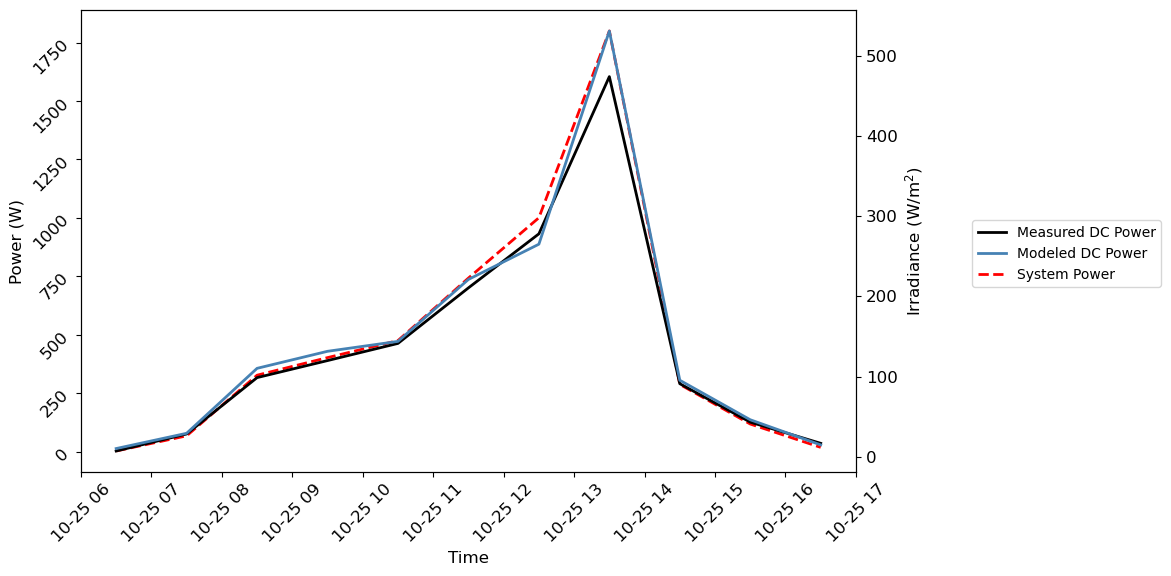

In [290]:
#diurnal plot
day = 25
month = 10
# print('RMSE: ', sklearn.metrics.mean_squared_error(df[(df.index.month == month) & (df.index.day == day)]['Modeled DC power'].dropna(),
#                            df[(df.index.month == month) & (df.index.day == day)]['Measured DC power'].dropna(), squared=False)     )
fig, ax = plt.subplots()
ax.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured DC power (W)'], linewidth=2, color='black', zorder=5.5)
ax.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Modeled DC power'], linewidth=2, color='steelblue', zorder=5.5)

ax.tick_params(labelrotation = 45)
ax.set_ylabel('Power (W)')
ax.set_xlabel('Time')
ax2 = ax.twinx()
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured front POA irradiance (W/m2)'], linewidth=2,linestyle='dashed',color='red',zorder=2.5)
ax2.set_ylabel('Irradiance (W/m$^2$)')
plt.grid(False)
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

line_1 = Line2D([0], [0], color='black', linewidth=2, linestyle='-',label='Measured DC Power')
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Modeled DC Power')
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label='System Power')
lines = [line_1,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.15, 0.4],handles=lines)

## 4. Compare modeled values to measured values + other baseline models

### 3 steps of analysis:
<li><b>1. Overall NMBE, MBE, RMSE, NRMSE, and other errors of the model</b></li>
<li><b>2. Residual analysis</b></li>
<li><b>3. Comparison to baseline model</b></li>

### Analysis I: Overall errors of the model
#### • Normalized Bias Error (NBE) - shows the estimation bias of the model
###                  $100 * \frac{V_{modeled} - V_{measured}}{V_{measured}}$


#### • Root Mean Squared Error (RMSE) - measures average difference between modeled and measured values
### $ \sqrt{\frac{1}{N} \sum_{i=1}^{N}(V_{modeled}-V_{measured})^2} $

In [291]:
df['NBE'] = 100 * (df['Modeled DC power'] - df['Measured DC power (W)'])/(df['Measured DC power (W)'])
nmbe = df['NBE'].mean()
df['BE'] = (df['Modeled DC power'] - df['Measured DC power (W)'])
mbe = df['BE'].mean()
rmse = sklearn.metrics.mean_squared_error(df.dropna()['Modeled DC power'],df.dropna()['Measured DC power (W)'], squared=False)
nrmse = 100 * rmse/(df['Measured DC power (W)'].mean())

d = [['NMBE', str(round(nmbe,3))+' %'], ['MBE', str(round(mbe,3))+' W'], ['NRMSE', str(round(nrmse,3))+' %'], ['RMSE',str(round(rmse,3))+' W']]
print (tabulate(d, headers=["Metric", "Value"]))

Metric    Value
--------  --------
NMBE      5.298 %
MBE       58.433 W
NRMSE     5.213 %
RMSE      87.643 W


### Plotting the measured vs modeled values
The plot should be mostly linear. r and slope values close to one indicate good correlation and accurate model performance

Text(500, 3000, '0.976x + -17.6505')

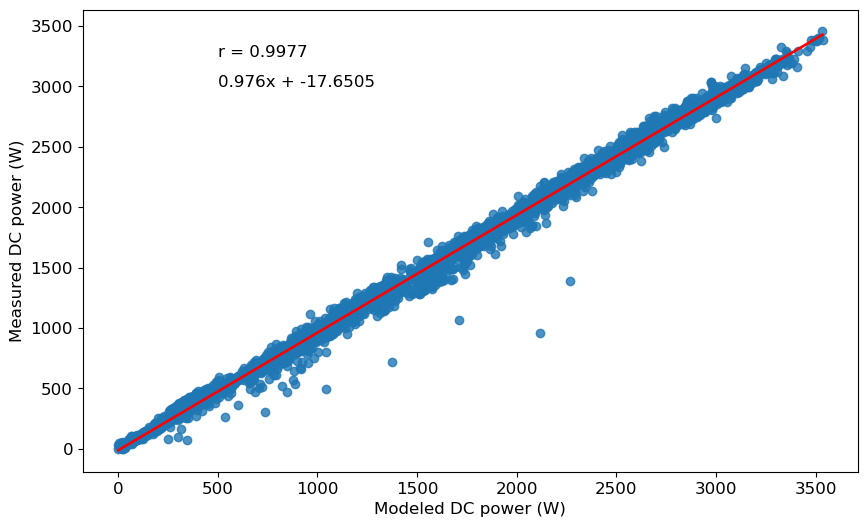

In [300]:
slope, intercept, r, p, std = scipy.stats.linregress(x = df.dropna()['Modeled DC power'], y = df.dropna()['Measured DC power (W)'])
sns.regplot(x = df['Modeled DC power'], y = df['Measured DC power (W)'], line_kws={'color':'red'})

plt.ylabel('Measured DC power (W)')
plt.xlabel('Modeled DC power (W)')
plt.text(500, 3250, s = ("r = "+str(round(r,4))))
plt.text(500, 3000, s = (str(round(slope,4))+'x + '+str(round(intercept,4))))

#plot should be mostly linear, r & slope values close to one indicate good correlation and accurate model performance

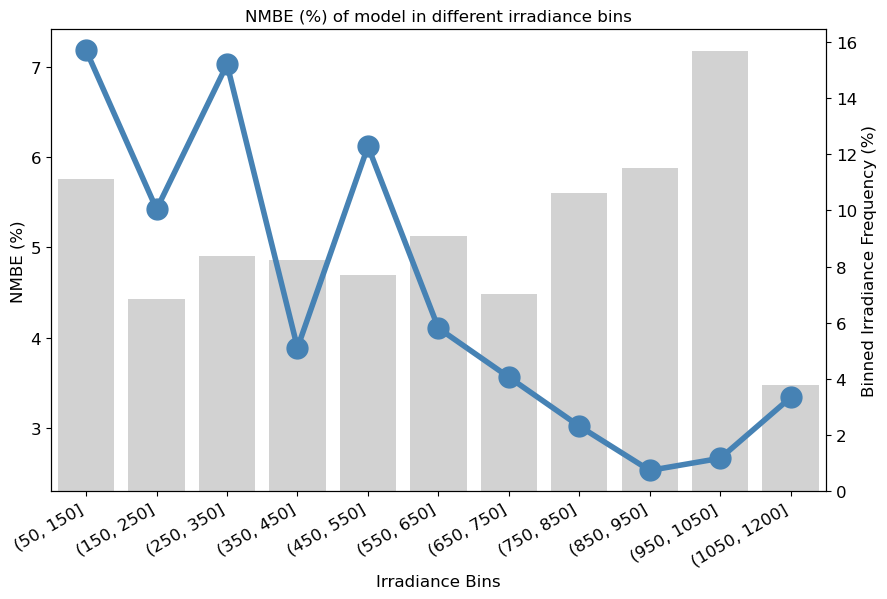

In [294]:
df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins.rename(columns = {'Irradiance Bins' : 'Frequency'}, inplace = True)
bins['Irradiance Bins'] = bins.index
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
y = df.groupby('Irradiance Bins').mean().sort_values('Irradiance Bins')['NBE']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=4, markersize=15)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('NMBE (%)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plt.title('NMBE (%) of model in different irradiance bins')
plt.show()


Text(0, 0.5, 'NMBE (%)')

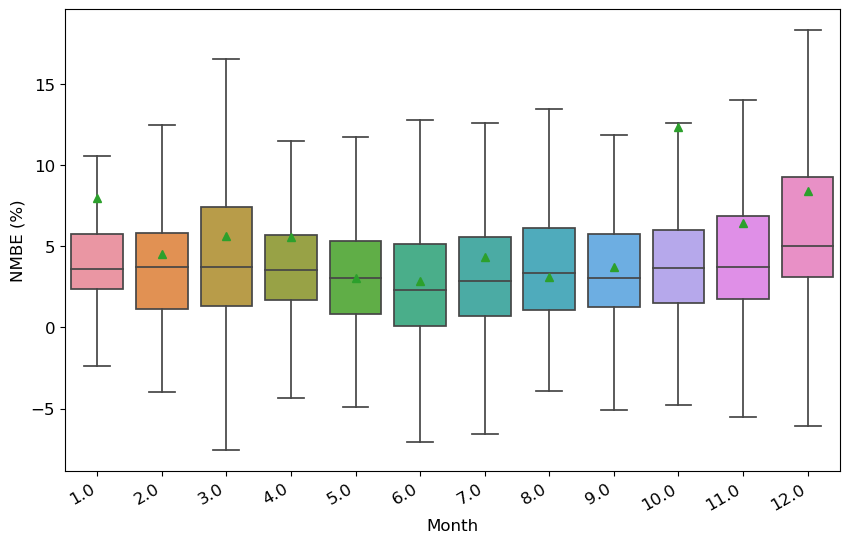

In [295]:
sns.boxplot(data=df, x='Month', y='NBE', showfliers=False, showmeans=True)
plt.xticks(rotation=30, ha='right')
plt.ylabel('NMBE (%)')

### Analemma Plots
These are another way to check seasonality of a model and can also show how the model performs at specific times of day

Text(0.5, 0, 'Solar Azimuth')

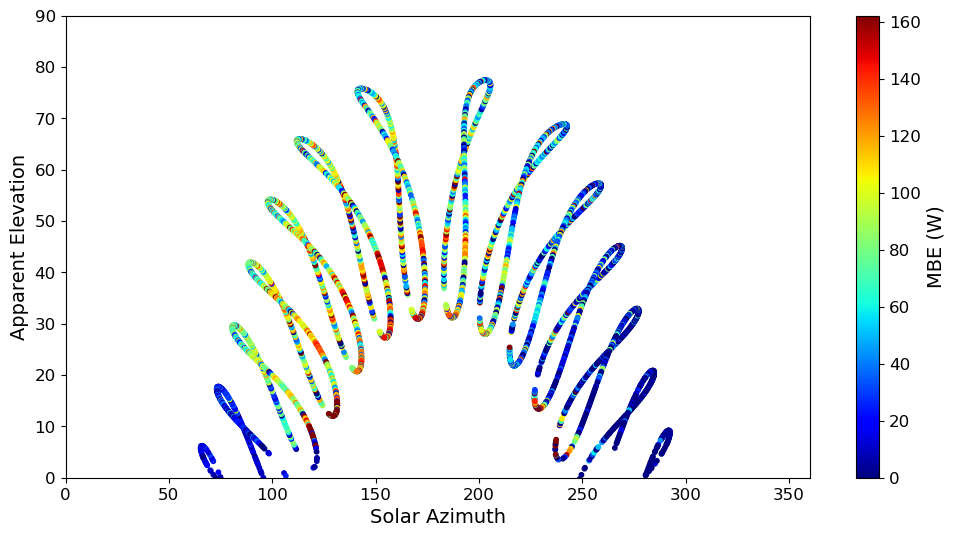

In [296]:
#analemma plots show the residuals at different times of the day/year
plt.figure(figsize=(12,6))
plt.scatter(x=df['Azimuth'], y=df['Sol Elev'], c=df['BE'], cmap='jet', s=10)
clb = plt.colorbar()
clb.ax.set_ylabel('MBE (W)',fontsize =14)
plt.clim(0,(df['BE'].describe()['75%'] + df['BE'].describe()['std']))
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation', fontsize=14 )
plt.xlabel('Solar Azimuth',fontsize =14)

### Energy Yield Estimates
We can run two simulations, one using the POA model and another using true POA data to see how much influence the errors of the model have on the overall energy yield

In [297]:
#find overall % diff for annual energy
print('The measured annual energy is', round(df['Measured DC power (W)'].sum()/1000,3),
      'kWh and the predicted annual energy using the model is', round(df['Modeled DC power'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate when using measured vs modeled POA is ', round(((df['Modeled DC power'].sum()-df['Measured DC power (W)'].sum())/df['Measured DC power (W)'].sum())*100,3),'%')

The measured annual energy is 6538.316 kWh and the predicted annual energy using the model is 6703.693 kWh
The % difference in energy estimate when using measured vs modeled POA is  2.529 %


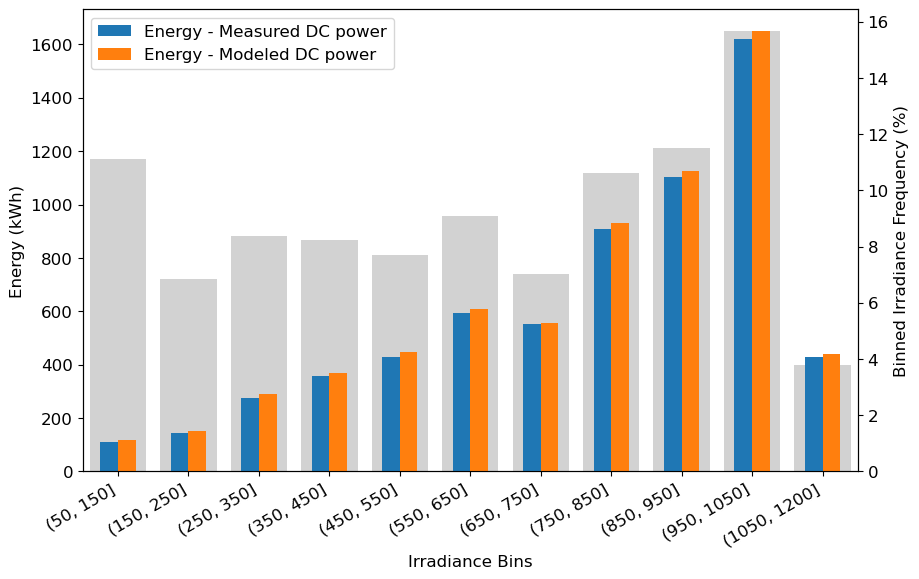

In [299]:
bins['Energy - Modeled DC power'] = df.groupby('Irradiance Bins').sum()['Modeled DC power']/1000
bins['Energy - Measured DC power'] = df.groupby('Irradiance Bins').sum()['Measured DC power (W)']/1000
bins = bins.sort_values('Irradiance Bins')

ax = bins.plot(x="Irradiance Bins", y=["Energy - Measured DC power", "Energy - Modeled DC power"], kind="bar", rot=0)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Energy (kWh)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

# plt.title('NMBE (%) of model in different irradiance bins')
plt.show()


### Analysis II: Residual Analysis
#### • Residual Analysis - quantifies the degree that variables may affect model errors
### $V_{modeled} - V_{measured}$

### Residual Distribution
Residuals should be normally distributed, otherwise this indicates a consistent bias of over or under predicting \
To get a closer look at a majority of the residuals, the outer 1% are removed using z-score. The distribution should be centered about the mean, shown by the red line

In [ ]:
add text to mean lines

Text(0.5, 0, 'Residuals (W)')

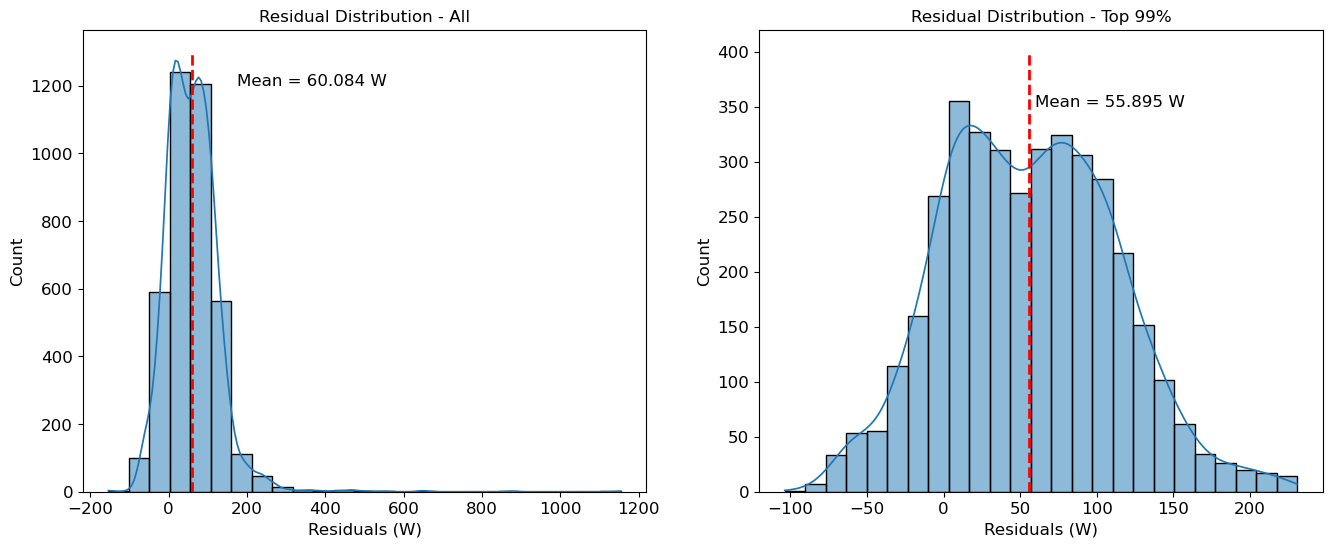

In [221]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

df['Residuals'] = df['Modeled DC power'] - df['Measured DC power (W)']
sns.histplot(df['Residuals'], kde=True, bins=25, ax=ax1)
ax1.vlines(x=df['Residuals'].mean(), ymin=0, ymax=1300, linewidth=2, color='red',linestyles='--')
ax1.text(175,1200,'Mean = '+str(round(df['Residuals'].mean(),3))+' W' )
ax1.set_title('Residual Distribution - All')
ax1.set_xlabel('Residuals (W)')

#Use z-score to eliminate the outer 1% of residuals
df['zscore'] = scipy.stats.zscore(df['Residuals'].dropna())
df['resid_trim'] = df['Residuals'][(df['zscore'] < 2.5) & (df['zscore'] > -2.5)]
sns.histplot(df['resid_trim'], kde=True, bins=25, ax=ax2)
ax2.vlines(x=df['resid_trim'].mean(), ymin=0, ymax=400, linewidth=2, color='red',linestyles='--')
ax2.text(60,350,'Mean = '+str(round(df['resid_trim'].mean(),3))+' W' )
ax2.set_title('Residual Distribution - Top 99%')
ax2.set_xlabel('Residuals (W)')

Text(764.6928104575164, 0.5, 'Model Residuals (W)')

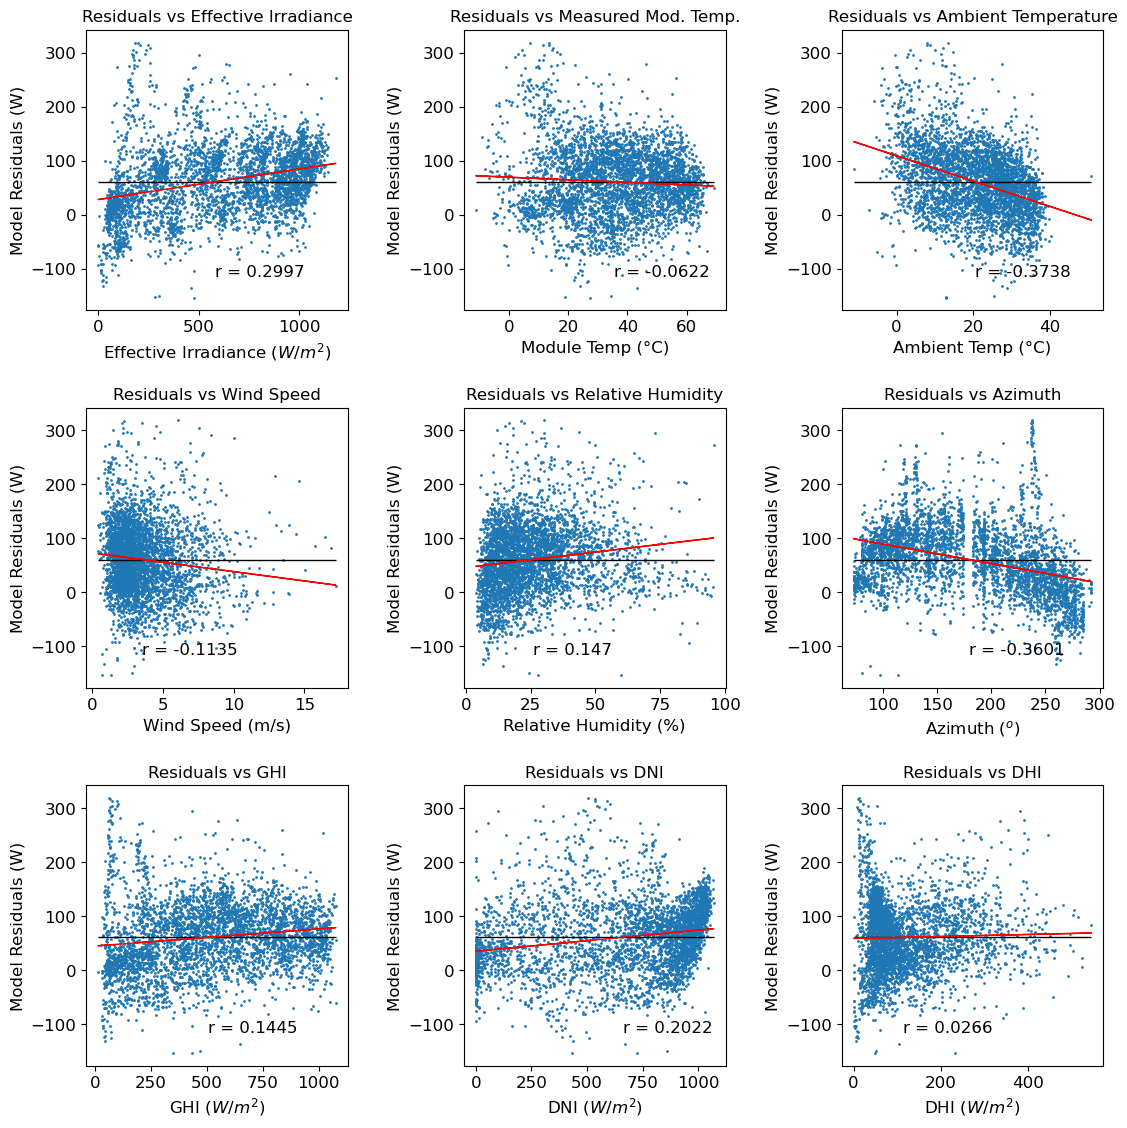

In [151]:
fig, axs = plt.subplots(3, 3,figsize=(12,12))
fig.tight_layout(pad=4.0)
# y = df['Residuals']
# y_avg = df['Residuals'].mean()
# y_med = df['Residuals'].median()
df = df.dropna()
y = df['resid_trim']
y_avg =  df['resid_trim'].mean()
y_med =  df['resid_trim'].median()

x = df['Effective Irradiance']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0, 0].scatter(x, y, s=1)
axs[0, 0].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0, 0].plot(x, p(x), linewidth=1, color='red')
axs[0, 0].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[0, 0].set_title('Residuals vs Effective Irradiance')
axs[0, 0].set_xlabel('Effective Irradiance ($W/m^2$)')
axs[0, 0].set_ylabel('Model Residuals (W)')
x = df['Measured module temperature (°C)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0, 1].scatter(x, y, s=1)
axs[0, 1].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0, 1].plot(x, p(x), linewidth=1, color='red')
axs[0, 1].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[0, 1].set_title('Residuals vs Measured Mod. Temp.')
axs[0, 1].set_xlabel('Module Temp (°C)')
axs[0, 1].set_ylabel('Model Residuals (W)')
x = df['Ambient Temp (°C) ']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0, 2].scatter(x, y, s=1)
axs[0, 2].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0, 2].plot(x, p(x), linewidth=1, color='red')
axs[0, 2].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[0, 2].set_title('Residuals vs Ambient Temperature')
axs[0, 2].set_xlabel('Ambient Temp (°C)')
axs[0, 2].set_ylabel('Model Residuals (W)')
x = df['Wind Speed (m/s)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1, 0].scatter(x, y, s=1)
axs[1, 0].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1, 0].plot(x, p(x), linewidth=1, color='red')
axs[1, 0].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[1, 0].set_title('Residuals vs Wind Speed')
axs[1, 0].set_xlabel('Wind Speed (m/s)')
axs[1, 0].set_ylabel('Model Residuals (W)')
x = df['Relative Humidity (%)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1, 1].scatter(x, y, s=1)
axs[1, 1].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1, 1].plot(x, p(x), linewidth=1, color='red')
axs[1, 1].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[1, 1].set_title('Residuals vs Relative Humidity')
axs[1, 1].set_xlabel('Relative Humidity (%)')
axs[1, 1].set_ylabel('Model Residuals (W)')
x = df['Azimuth']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1, 2].scatter(x, y, s=1)
axs[1, 2].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1, 2].plot(x, p(x), linewidth=1, color='red')
axs[1, 2].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[1, 2].set_title('Residuals vs Azimuth')
axs[1, 2].set_xlabel('Azimuth ($^o$)')
axs[1, 2].set_ylabel('Model Residuals (W)')
x = df['GHI (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[2, 0].scatter(x, y, s=1)
axs[2, 0].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[2, 0].plot(x, p(x), linewidth=1, color='red')
axs[2, 0].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[2, 0].set_title('Residuals vs GHI')
axs[2, 0].set_xlabel('GHI ($W/m^2$)')
axs[2, 0].set_ylabel('Model Residuals (W)')
x = df['DNI (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[2, 1].scatter(x, y, s=1)
axs[2, 1].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[2, 1].plot(x, p(x), linewidth=1, color='red')
axs[2, 1].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[2, 1].set_title('Residuals vs DNI')
axs[2, 1].set_xlabel('DNI ($W/m^2$)')
axs[2, 1].set_ylabel('Model Residuals (W)')
x = df['DHI (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[2, 2].scatter(x, y, s=1)
axs[2, 2].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[2, 2].plot(x, p(x), linewidth=1, color='red')
axs[2, 2].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[2, 2].set_title('Residuals vs DHI')
axs[2, 2].set_xlabel('DHI ($W/m^2$)')
axs[2, 2].set_ylabel('Model Residuals (W)')


check r R

### Residuals by month
Grouping the residuals by month is one way to check if the model has any extreme behavior in specific seasons of the year \
This is done below with a boxplot which shows the spread of the data within the months and a jointplot which can show this and the distribution of the data across the months as well

In [155]:
df.Month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

(-174.60128738178685, 292.3939029142599)

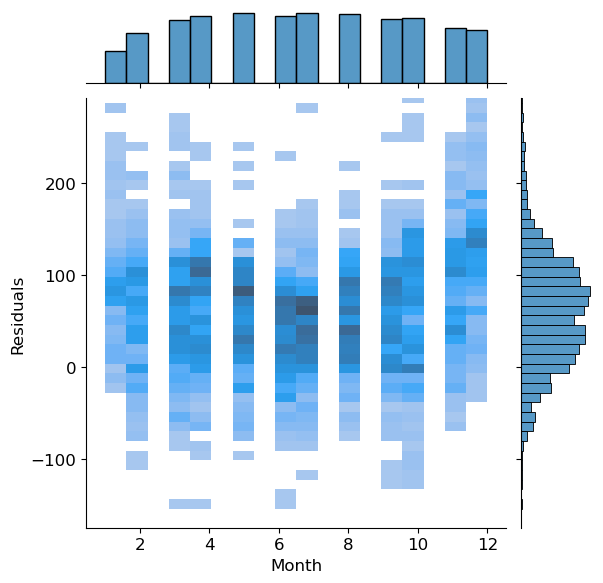

In [153]:
sns.jointplot(data=df, x='Month', y='Residuals', kind='hist')#, space=0, marginal_ticks=True)
plt.ylim((-1*abs((df['Residuals'].describe()['25%']) - abs(3*df['Residuals'].describe()['std']))),abs((df['Residuals'].describe()['75%']) + abs(3*df['Residuals'].describe()['std'])))

### Empirical Cumulative Distribution Plot (ECDF)
This plot shows the cumulative distribution of the residuals with the median as the dashed line and the mean as the solid line

In [225]:
df['resid_trim'].dropna()

2021-01-01 08:30:00-07:00    212.041443
2021-01-01 09:30:00-07:00     86.435703
2021-01-01 10:30:00-07:00    102.095508
2021-01-01 11:30:00-07:00     88.215977
2021-01-01 12:30:00-07:00     33.445256
                                ...    
2021-12-31 11:30:00-07:00    152.068235
2021-12-31 12:30:00-07:00    134.020254
2021-12-31 13:30:00-07:00    100.805714
2021-12-31 14:30:00-07:00     56.732342
2021-12-31 15:30:00-07:00    141.049263
Name: resid_trim, Length: 3827, dtype: float64

In [233]:
(df['resid_trim'].dropna(), 50)

(2021-01-01 08:30:00-07:00    212.041443
 2021-01-01 09:30:00-07:00     86.435703
 2021-01-01 10:30:00-07:00    102.095508
 2021-01-01 11:30:00-07:00     88.215977
 2021-01-01 12:30:00-07:00     33.445256
                                 ...    
 2021-12-31 11:30:00-07:00    152.068235
 2021-12-31 12:30:00-07:00    134.020254
 2021-12-31 13:30:00-07:00    100.805714
 2021-12-31 14:30:00-07:00     56.732342
 2021-12-31 15:30:00-07:00    141.049263
 Name: resid_trim, Length: 3827, dtype: float64,
 50)

Text(140.97228046413585, 0.2, 'P50 = 128.157 W')

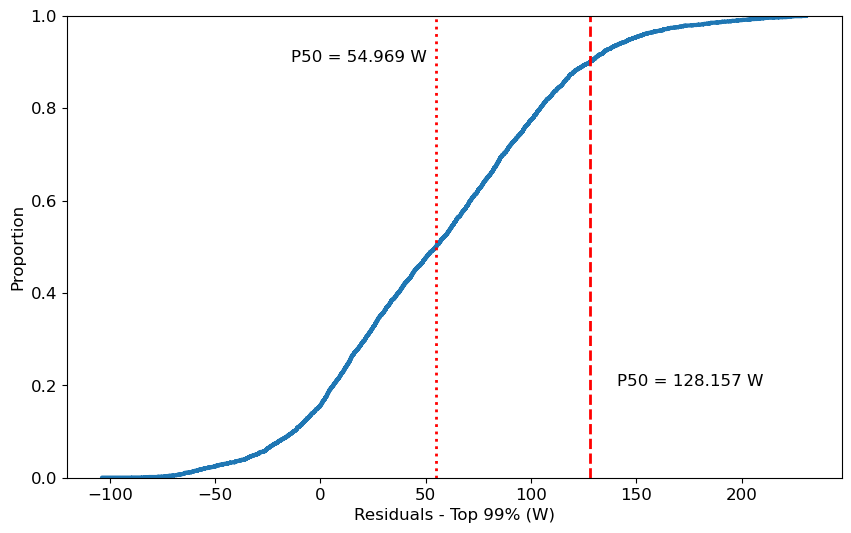

In [242]:
#plot empirical cumulative distribution functions
sns.ecdfplot(data=df, x='resid_trim', linewidth=3)
plt.xlabel('Residuals - Top 99% (W)')
plt.vlines(x=np.percentile(df['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='red',linestyles='dotted')
plt.text((np.percentile(df['resid_trim'].dropna(), 50) - (1.25*np.percentile(df['resid_trim'].dropna(), 50))), 0.9, 'P50 = '+str(round(np.percentile(df['resid_trim'].dropna(), 50),3))+' W')
plt.vlines(x=np.percentile(df['resid_trim'].dropna(), 90), ymin=0, ymax=1, linewidth=2, color='red',linestyles='--')
plt.text((np.percentile(df['resid_trim'].dropna(), 90) + (0.1*np.percentile(df['resid_trim'].dropna(), 90))), 0.2, 'P90 = '+str(round(np.percentile(df['resid_trim'].dropna(), 90),3))+' W')

### Relative Efficiency

####  Calculate the temperature corrected efficiency:
##  $\eta_{@ 25°C} = \frac{Power * (1 + \gamma*(25°C - T_{Module}))}{POA * Area}$

#### Then calculate the nominal efficiency by taking the median efficiency using measured module performance when irradiance is ~1000 $W/m^2$ and AOI < 70°
##### The range around 1000 $W/m^2$ can vary based on location and annual irradiance values

In [278]:
#temperature corrected efficiency
df['Eff at 25C'] = df['Modeled DC power'] * (1 + (-0.0041 * (25 - (df['Measured module temperature (°C)']))))/(df['Measured front POA irradiance (W/m2)'] * module['Area'])

In [279]:
#determining nominal efficiency
low_lim = 950
upp_lim = 1050
aoi_lim = 70
df_eff = df.loc[(df['Effective Irradiance'] > low_lim) & (df['Effective Irradiance'] > upp_lim) & (df['AOI'] < aoi_lim)]
eff_nom = ((df_eff['Modeled DC power'] * (1 + (-0.0041 * (25 - (df['Measured module temperature (°C)'])))))/(df_eff['Measured front POA irradiance (W/m2)'] * module['Area'])).median()

In [281]:
df['Relative Efficiency'] = df['Eff at 25C']/eff_nom

(0.6, 1.3)

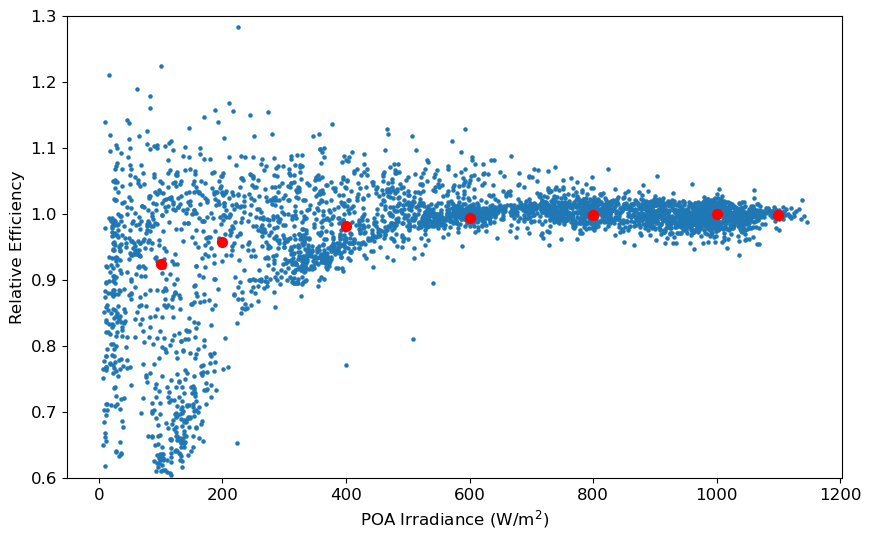

In [282]:
plt.scatter(df['Measured front POA irradiance (W/m2)'],df['Relative Efficiency'], s=5)
plt.scatter(efficiency['Irradiance'], efficiency['Relative Efficiency'], s=50, c='red')
plt.ylabel('Relative Efficiency')
plt.xlabel('POA Irradiance (W/m$^2$)')
plt.ylim(0.6,1.3)


### Analysis III: Comparison to Baseline Models
##### Comparing the model to other well-known baseline models can provide information about how the model is performing relative to accepted models

In [ ]:
# run a baseline model with the same inputs as test model
#Run PVW and calculate string power
pvw_pdc = pvlib.pvsystem.pvwatts_dc(g_poa_effective = df['Effective Irradiance'], temp_cell = df['Cell Temperature'], 
            pdc0 = 275,gamma_pdc = -0.0041)
df['PVWatts'] = (pvw_pdc*module['String Length'])
df['Residuals PVW'] = df['PVWatts'] - df['Measured DC power (W)']

In [ ]:
nbe_df

In [ ]:
nbe = []
pvw = 100 * ((df['PVWatts'] - df['Measured DC power (W)'])/(df['Measured DC power (W)'])).to_frame()
pvw.rename(columns = {0 : 'NBE'}, inplace = True)
pvw['Model'] = 'PVWatts'
nbe.append(pvw)
test =  100 * ((df['Modeled DC power'] - df['Measured DC power (W)'])/(df['Measured DC power (W)'])).to_frame()
test.rename(columns = {0 : 'NBE'}, inplace = True)
test['Model'] = model_name
nbe.append(test)
nbe_df = pd.concat(nbe, ignore_index=True)
sns.barplot(x='Model', y='NBE', data=nbe_df)
plt.ylabel('NMBE (%)')
# sns.boxplot(x='Model', y='NBE', data=nbe_df, showmeans=True, showfliers = False)